Dataset Shape: (15151, 16)
             timestamp  active_power_calculated_by_converter  \
0  2021-02-19 20:18:00                            816.636759   
1  2021-04-27 04:55:00                            419.107829   
2  2021-01-25 06:26:00                           1303.530558   
3  2021-10-30 03:47:00                             61.494872   
4  2021-03-15 00:39:00                            593.514364   

   active_power_raw  ambient_temperature  generator_speed  \
0        834.917206            31.694380      1159.616602   
1        421.050873            12.894948       928.747996   
2       1337.566142            16.648388      1201.219775   
3         53.481008            28.388141       769.806122   
4        611.659108            31.519527      1046.916768   

   generator_winding_temp_max  grid_power10min_average  nc1_inside_temp  \
0                   65.954214               917.897085        31.881972   
1                   59.571319               445.554250        32.423705

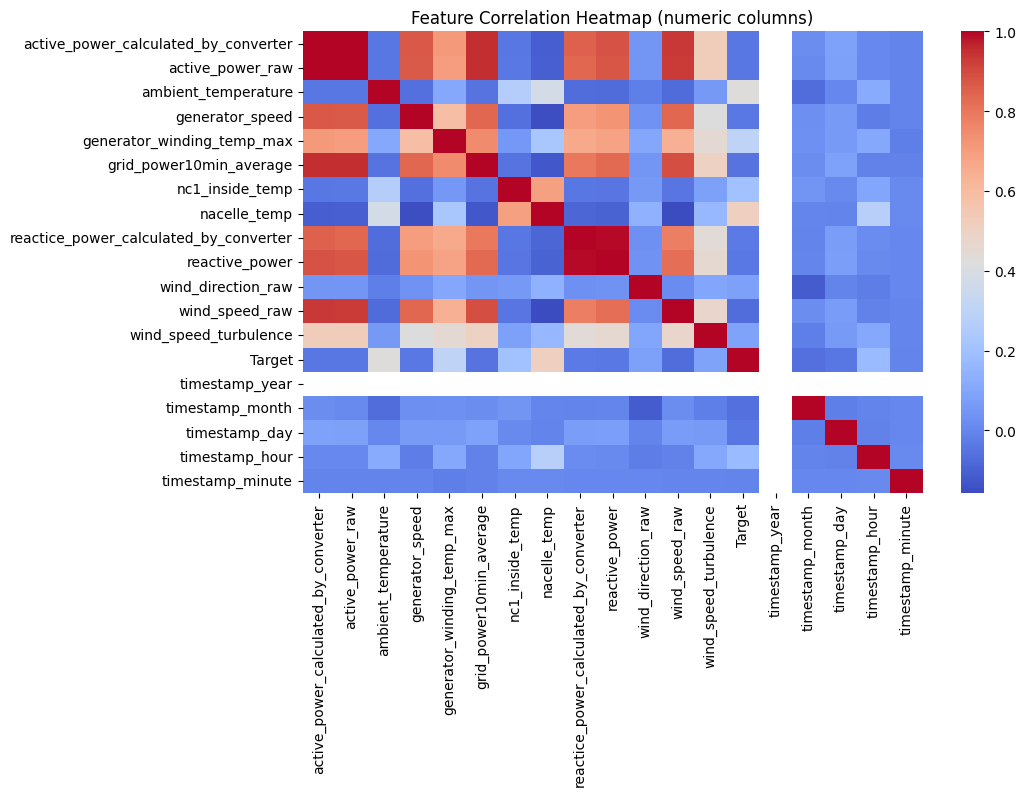

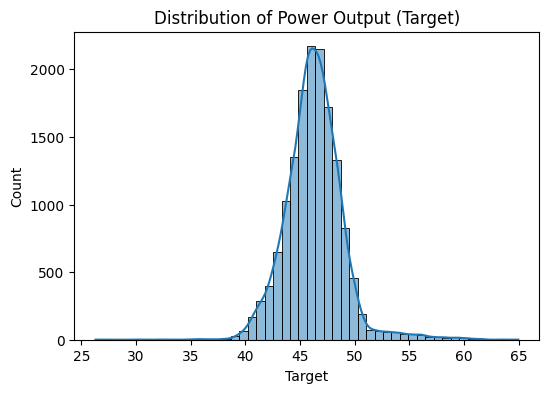

After dropna shape: (15150, 20)
Categorical columns to encode: ['turbine_id']
Final feature shape (after encoding/coercion): (15150, 33)

Linear Regression Performance:
  RMSE: 1.727
  MAE: 1.213
  R²: 0.572

Random Forest Performance:
  RMSE: 1.158
  MAE: 0.793
  R²: 0.808

XGBoost Performance:
  RMSE: 1.102
  MAE: 0.749
  R²: 0.826

Model Comparison:
                        RMSE       MAE        R²
Linear Regression  1.726506  1.212807  0.572108
Random Forest      1.157911  0.792948  0.807537
XGBoost            1.102457  0.749418  0.825530


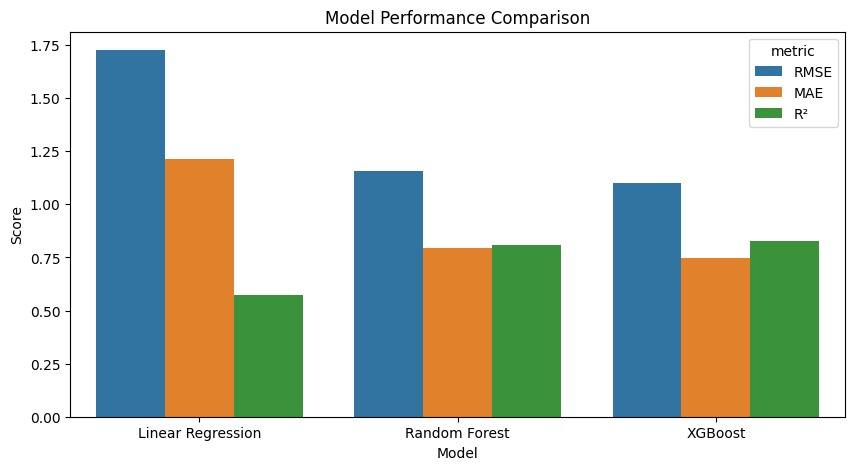

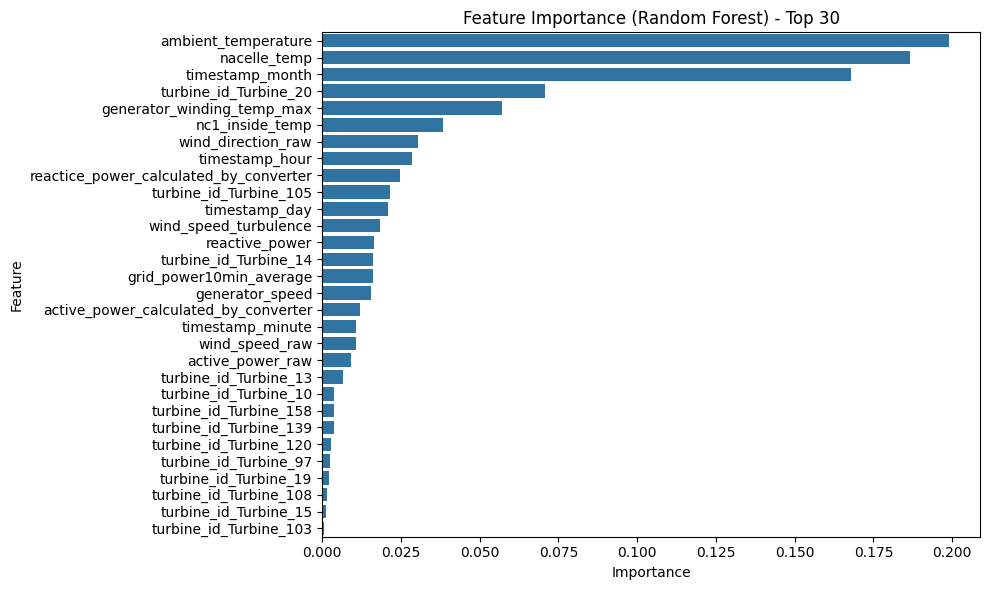

Selected best model: XGBoost


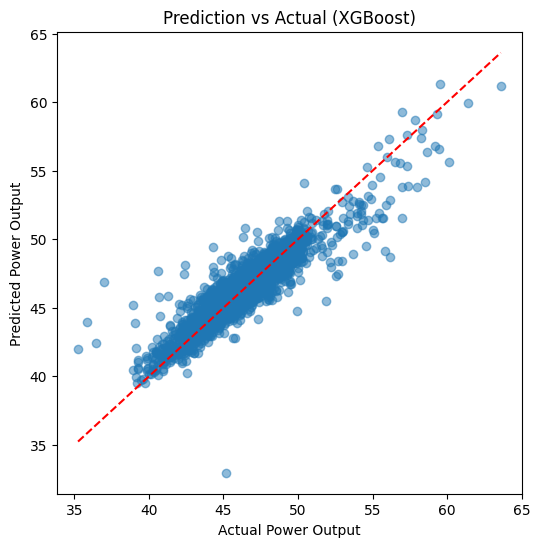


✅ Best model saved as wind_power_model.pkl and scaler saved as scaler.pkl


In [2]:
# Wind Turbine Power Output Prediction - Debugged & Robust Version
# GreenWatt Energy Solutions - Major Project

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Optional XGBoost (if installed)
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception as e:
    print("XGBoost not available, skipping XGB model. Error:", e)
    xgb_available = False

# --------------------------
# 1. Load Dataset
# --------------------------
df = pd.read_csv("train.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# --------------------------
# 2. Detect & handle datetime columns robustly
# --------------------------
datetime_detected = []
for col in df.select_dtypes(include=['object', 'category']).columns:
    coerced = pd.to_datetime(df[col], errors='coerce')
    non_null_ratio = coerced.notnull().mean()
    # if at least half of values convert to datetime -> treat column as datetime
    if non_null_ratio > 0.5:
        df[col] = coerced
        datetime_detected.append(col)
        # extract components with names that include original column name
        df[f"{col}_year"] = df[col].dt.year
        df[f"{col}_month"] = df[col].dt.month
        df[f"{col}_day"] = df[col].dt.day
        df[f"{col}_hour"] = df[col].dt.hour
        df[f"{col}_minute"] = df[col].dt.minute
        # drop the original datetime column
        df.drop(columns=[col], inplace=True)

print("Datetime columns converted:", datetime_detected)

# --------------------------
# 3. Quick EDA & safe correlation
# --------------------------
print("\nMissing values (first 20 cols):\n", df.isnull().sum().head(20))
print("\nDataset Description (numeric):\n", df.describe())

# Correlation heatmap on numeric columns only
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] > 1:
    plt.figure(figsize=(10,6))
    sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
    plt.title("Feature Correlation Heatmap (numeric columns)")
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

# Distribution of target
if 'Target' not in df.columns:
    raise KeyError("No 'Target' column found in dataset. Rename your target column to 'Target' or update the script.")
# coerce target to numeric if needed
if not np.issubdtype(df['Target'].dtype, np.number):
    df['Target'] = pd.to_numeric(df['Target'], errors='coerce')

plt.figure(figsize=(6,4))
sns.histplot(df['Target'].dropna(), bins=50, kde=True)
plt.title("Distribution of Power Output (Target)")
plt.show()

# --------------------------
# 4. Data cleaning & preprocessing
# --------------------------
# Drop rows with missing values (after we've coerced target/datetimes)
df = df.dropna().reset_index(drop=True)
print("After dropna shape:", df.shape)

# Split features and target
X = df.drop(columns=['Target'])
y = df['Target']

# Encode categorical variables (object/category) using one-hot encoding
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_cols:
    print("Categorical columns to encode:", cat_cols)
    # Use get_dummies (drop_first=True to reduce dimensionality)
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Ensure all features are numeric; coerce anything left and drop rows if necessary
non_numeric_mask = ~X.applymap(np.isreal).all(axis=0) if X.shape[1] > 0 else pd.Series(dtype=bool)
# A simpler robust approach: try to coerce all columns to numeric (this will convert booleans/ints fine)
X = X.apply(pd.to_numeric, errors='coerce')

# If coercion produced NaNs, drop rows from X and corresponding y
combined = pd.concat([X, y], axis=1)
combined = combined.dropna().reset_index(drop=True)
X = combined.drop(columns=['Target'])
y = combined['Target']

print("Final feature shape (after encoding/coercion):", X.shape)

# --------------------------
# 5. Train-Test split & scaling
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# 6. Model training
# --------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42)
}
if xgb_available:
    models["XGBoost"] = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbosity=0)

results = {}
fitted_models = {}

for name, model in models.items():
    try:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {"RMSE": rmse, "MAE": mae, "R²": r2}
        fitted_models[name] = model

        print(f"\n{name} Performance:")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  MAE: {mae:.3f}")
        print(f"  R²: {r2:.3f}")
    except Exception as e:
        print(f"Failed to train/evaluate model {name}. Error: {e}")

# --------------------------
# 7. Compare models (table + plot)
# --------------------------
results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df)

if not results_df.empty:
    # Plot (melted so different metrics are shown)
    melted = results_df.reset_index().melt(id_vars='index', var_name='metric', value_name='value')
    plt.figure(figsize=(10,5))
    sns.barplot(data=melted, x='index', y='value', hue='metric')
    plt.title("Model Performance Comparison")
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.show()
else:
    print("No model results to show.")

# --------------------------
# 8. Feature importance (Random Forest if available)
# --------------------------
if "Random Forest" in fitted_models:
    rf_model = fitted_models["Random Forest"]
    importances = rf_model.feature_importances_
    features = X.columns
    feat_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(30)  # show top 30 for clarity

    plt.figure(figsize=(10,6))
    sns.barplot(data=feat_imp, x='Importance', y='Feature')
    plt.title("Feature Importance (Random Forest) - Top 30")
    plt.tight_layout()
    plt.show()
else:
    print("Random Forest not trained; skipping feature importance.")

# --------------------------
# 9. Prediction vs Actual (for best model)
# --------------------------
if results:
    # choose best model by RMSE (lower better)
    best_name = min(results.keys(), key=lambda n: results[n]['RMSE'])
    best_model = fitted_models[best_name]
    print(f"Selected best model: {best_name}")

    y_pred_best = best_model.predict(X_test_scaled)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred_best, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Power Output")
    plt.ylabel("Predicted Power Output")
    plt.title(f"Prediction vs Actual ({best_name})")
    plt.show()

    # --------------------------
    # 10. Save best model + scaler
    # --------------------------
    joblib.dump(best_model, "wind_power_model.pkl")
    joblib.dump(scaler, "scaler.pkl")
    print("\n✅ Best model saved as wind_power_model.pkl and scaler saved as scaler.pkl")
else:
    print("No trained models to save.")